# Analysis and estimation of duration distributions in empirical data

In [1]:
import pomegranate
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("Train_NPS_evlog_activity_duration.csv")

In [3]:
df['date_task_created'] = pd.to_datetime(df['date_task_created']) #, format='%Y-%m-%d %H:%M:%S'
df['date_case_created'] = pd.to_datetime(df['date_case_created'])
df['date_case_closed'] = pd.to_datetime(df['date_case_closed'])
df['nps_createddate'] = pd.to_datetime(df['nps_createddate'])
df

,case_id,case_type,task_id,task_tasksubtype,ressource,ressource_role,case_owner_role,case_topic,case_requires_rework__c,case_closure_code__c,...,date_case_closed,date_task_created,year,month,day,weekday,hour,activity_timestep,activity_duration_hrs,activity_duration_days
0,1925130,Service Request,2853,Interaction,r_6,b_1,b_1,z_3,False,Changed subscription,...,2019-05-21 22:01:08+00:00,2019-05-13 12:05:52+00:00,2019,5,13,0,12,3_Email,154.721667,6.446736
1,1925130,Service Request,2870,Email,r_6,b_1,b_1,z_3,False,Changed subscription,...,2019-05-21 22:01:08+00:00,2019-05-14 06:34:25+00:00,2019,5,14,1,6,3_Email,154.721667,6.446736
2,1925130,Service Request,2888,Email,r_6,b_1,b_1,z_3,False,Changed subscription,...,2019-05-21 22:01:08+00:00,2019-05-15 11:17:50+00:00,2019,5,15,2,11,3_Email,154.721667,6.446736
3,2048019,Service Request,4246,Interaction,n_5,b_1,b_1,j_1,False,Information/guidance given,...,2019-10-02 22:01:08+00:00,2019-09-26 06:17:29+00:00,2019,9,26,3,6,2_Email,159.674167,6.653090
4,2048019,Service Request,4248,Email,n_5,b_1,b_1,j_1,False,Information/guidance given,...,2019-10-02 22:01:08+00:00,2019-09-26 06:20:41+00:00,2019,9,26,3,6,2_Email,159.674167,6.653090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5451,1703924,Service Request,1305,Email,a_9,g_1,g_1,w_2,False,Information/guidance given,...,2018-11-18 23:01:13+00:00,2018-11-12 13:27:23+00:00,2018,11,12,0,13,5_Email,153.563889,6.398495
5452,1712117,Service Request,1022,Interaction,w_7,b_1,b_1,w_1,False,Information/guidance given,...,2018-10-30 23:00:13+00:00,2018-10-24 12:21:48+00:00,2018,10,24,2,12,2_Email,154.456944,6.435706
5453,1712117,Service Request,1023,Email,w_7,b_1,b_1,w_1,False,Information/guidance given,...,2018-10-30 23:00:13+00:00,2018-10-24 12:32:48+00:00,2018,10,24,2,12,2_Email,154.456944,6.435706
5454,2031609,Service Request,3980,Interaction,l_6,b_1,b_1,g_1,False,Changed subscription,...,2019-09-11 22:00:55+00:00,2019-09-05 07:59:43+00:00,2019,9,5,3,7,2_Email,157.931667,6.580486


In [4]:
df.columns

Index(['case_id', 'case_type', 'task_id', 'task_tasksubtype', 'ressource',
       'ressource_role', 'case_owner_role', 'case_topic',
       'case_requires_rework__c', 'case_closure_code__c',
       'case_milestonestatus', 'case_resolution_time__c', 'nps_createddate',
       'nps_response_complete', 'nps_promoter', 'nps_detractor',
       'nps_response_value', 'task_count', 'task_number', 'date_case_created',
       'date_case_closed', 'date_task_created', 'year', 'month', 'day',
       'weekday', 'hour', 'activity_timestep', 'activity_duration_hrs',
       'activity_duration_days'],
      dtype='object')

# Get cases only

In [5]:
#drop the generated duplicates:
print(len(df))

df = df.drop_duplicates(subset=["case_id"],keep='first')
print(len(df))

5456
1898


# Sort cases

In [6]:
df = df.sort_values(by='date_case_created')
df['date_case_created']

2230   2018-02-12 11:40:54
284    2018-02-19 14:30:46
543    2018-02-20 10:17:59
644    2018-02-20 13:02:14
699    2018-02-20 14:03:19
               ...        
1707   2019-12-17 08:37:15
1928   2019-12-17 11:36:50
1931   2019-12-17 11:37:07
1963   2019-12-17 11:54:45
2028   2019-12-17 12:26:32
Name: date_case_created, Length: 1898, dtype: datetime64[ns]

# Get duration between cases

In [7]:
cases = list(df.case_id.values)
print(len(cases))

1898


In [8]:
#placeholder for all rows
evlog = []

#go over all cases
for idx in range(0,len(cases)):
    
    if idx < len(cases)-1:
        caseid1 = cases[idx]
        caseid2 = cases[idx+1]

        
        #subset the case
        case1 = df.loc[df.case_id == caseid1]
        case2 = df.loc[df.case_id == caseid2]
        
        start1 = case1.loc[case1.index[0]].date_case_created
        start2 = case2.loc[case2.index[0]].date_case_created
        
        #calculate difference between events, and get duration:
        duration = start2 - start1
        duration = duration.total_seconds()/60/60 #hours
        
        #store result
        case1["time_to_next_case_hrs"] = duration
        
        evlog.append(case1)
        
evlog_df = pd.concat(evlog, ignore_index=True)
evlog_df

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case1["time_to_next_case_hrs"] = duration
<ipython-input-8-541afb97878b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,case_id,case_type,task_id,task_tasksubtype,ressource,ressource_role,case_owner_role,case_topic,case_requires_rework__c,case_closure_code__c,...,date_task_created,year,month,day,weekday,hour,activity_timestep,activity_duration_hrs,activity_duration_days,time_to_next_case_hrs
0,1485898,Service Request,1,Email,y_7,b_1,b_1,d_2,False,Changed subscription,...,2018-02-12 11:42:22+00:00,2018,2,12,0,11,2_Email,155.063611,6.460984,170.831111
1,1491365,Service Request,3,Email,y_6,i_1,i_1,j_1,False,Information/guidance given,...,2018-02-19 14:31:36+00:00,2018,2,19,0,14,2_Email,152.390000,6.349583,19.786944
2,1491822,Service Request,5,Email,y_9,i_1,i_1,d_2,False,Information/guidance given,...,2018-02-20 10:20:20+00:00,2018,2,20,1,10,3_Email,252.501944,10.520914,2.737500
3,1492023,Service Request,6,Email,y_8,i_1,i_1,q_3,False,Information/guidance given,...,2018-02-20 13:03:14+00:00,2018,2,20,1,13,3_Email,159.200833,6.633368,1.018056
4,1492100,Service Request,7,Email,y_3,i_1,i_1,d_2,False,Information/guidance given,...,2018-02-20 14:04:53+00:00,2018,2,20,1,14,2_Email,151.677500,6.319896,43.977500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,2116015,Service Request,5436,Interaction,a_9,b_1,b_1,r_2,False,Information/guidance given,...,2019-12-17 08:28:55+00:00,2019,12,17,1,8,2_Email,158.447778,6.601991,0.113611
1893,2116031,Service Request,5440,Interaction,i_9,g_1,g_1,q_3,False,Information/guidance given,...,2019-12-17 09:01:20+00:00,2019,12,17,1,9,2_Email,157.676667,6.569861,2.993056
1894,2116341,Service Request,5443,Interaction,a_10,b_2,b_1,z_4,False,Information/guidance given,...,2019-12-17 11:33:59+00:00,2019,12,17,1,11,3_Email,154.275000,6.428125,0.004722
1895,2116343,Service Request,5444,Interaction,w_7,b_1,b_1,z_3,False,Information/guidance given,...,2019-12-17 11:35:48+00:00,2019,12,17,1,11,3_Email,154.085278,6.420220,0.293889


# Drop duplicates created in the loop

In [10]:
#drop the generated duplicates:
print(len(df))
print(len(evlog_df))

evlog_df = evlog_df.drop_duplicates(subset=["case_id"])
print(len(evlog_df))

1898
1897
1897


# analysis

<AxesSubplot:>

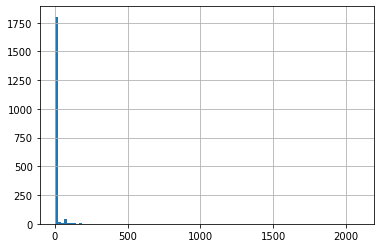

In [11]:
evlog_df.time_to_next_case_hrs.hist(bins=100)

# Save data for further modelling

In [12]:
evlog_df.to_csv("Train_NPS_evlog_case_arrivals.csv",index=False)

In [13]:
evlog_df.to_csv("../../../Analysis/2_arrival_times/Train_NPS_evlog_case_arrivals.csv",index=False)